In [7]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
np.random.seed(1234)

In [9]:
## load data
water_pumps = pd.read_csv('data/water_pump_set.csv', index_col='id', parse_dates=['date_recorded'])
water_pumps_labels = pd.read_csv('data/water_pump_labels.csv', index_col='id', dtype={'status_group': 'category'})

## join dataframes on index
water_pumps_df = water_pumps.join(water_pumps_labels)

# water_pumps_df.info()

In [10]:
############# EDA: EXPLORATORY DATA ANALYSIS #############
## data cleaning 
# count overlapping values between two similar columns
extraction_overlap = (sum(np.where(water_pumps_df['extraction_type'] == water_pumps_df['extraction_type_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'extraction_type' and 'extraction_type_group'".format(extraction_overlap))

quantity_overlap = (sum(np.where(water_pumps_df['quantity'] == water_pumps_df['quantity_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'quantity' and 'quantity_group'".format(quantity_overlap))

waterpoint_overlap = (sum(np.where(water_pumps_df['waterpoint_type'] == water_pumps_df['waterpoint_type_group'], True, False)) / len(water_pumps_df)) * 100
print("{:.1f}% matching values between columns 'waterpoint_type' and 'waterpoint_type_group'".format(waterpoint_overlap))

# count number of occurrences of unique values
print(water_pumps_df['management_group'].value_counts())

# check for duplicate columns (but different category names)
print(water_pumps_df['payment_type'].value_counts())
print(water_pumps_df['payment'].value_counts())

print(water_pumps_df['water_quality'].value_counts())
print(water_pumps_df['quality_group'].value_counts())

print(water_pumps_df['source'].value_counts())
print(water_pumps_df['source_type'].value_counts())

# drop unuseful columns
water_pumps_df = water_pumps_df.drop(columns=['funder', 'region', 'num_private', 'recorded_by', 'scheme_name', 'extraction_type_group', 'management_group', 'payment', 'quantity_group', 'quality_group', 'source_type', 'waterpoint_type_group'])

# set incorrect values to nan
# water_pumps_df['construction_year'] = water_pumps_df['construction_year'].replace(0, np.nan)
water_pumps_df['longitude'] = water_pumps_df['longitude'].replace(0, np.nan)

# water_pumps_df.info()

95.8% matching values between columns 'extraction_type' and 'extraction_type_group'
100.0% matching values between columns 'quantity' and 'quantity_group'
89.7% matching values between columns 'waterpoint_type' and 'waterpoint_type_group'
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride a

In [11]:
## set dtypes
# convert columns to bool
# to_bool = ['public_meeting', 'permit']
# water_pumps_df[to_bool] = water_pumps_df[to_bool].astype('boolean')

# convert some numeric columns to categorical
to_categorical = ['district_code', 'region_code']
water_pumps_df[to_categorical] = water_pumps_df[to_categorical].astype('category')

# set remaining (non-numeric) columns to categorical
to_categorical = water_pumps_df.select_dtypes(include='object').columns.tolist()
water_pumps_df[to_categorical] = water_pumps_df[to_categorical].astype('category')

# water_pumps_df.info()

In [12]:
## missing values treatment
# determine number of missing values per column
print("---------Missing values---------: \n {}".format(water_pumps_df.isna().sum(axis=0)))

# create bins for column with too many missing valyes (or drop?)
water_pumps_df['construction_year_group'] = pd.cut(x=water_pumps_df['construction_year'], 
    bins=[-1, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], 
    labels=['Unknown', '1960s', '1970s', '1980s', '1090s', '2000s', '2010s', '2020s'])

# drop columns with too many missing values (+/- 50%)
water_pumps_df = water_pumps_df.drop(columns=['construction_year'])

# fill na's of numerical columns with mean
water_pumps_df['longitude'] = water_pumps_df['longitude'].fillna(water_pumps_df['longitude'].mean())

# fill na's of categorical columns with mode
# NOTE: check for class imbalance due to imputation -- alternative would be to assign new category 'Other'
categorical_columns = water_pumps_df.select_dtypes(include='category').columns.tolist()
for col in categorical_columns:
    water_pumps_df[col].fillna(water_pumps_df[col].value_counts().idxmax(), inplace=True)

# TO DO: replace nan with 'unknown' for boolean values
water_pumps_df = water_pumps_df.dropna()

---------Missing values---------: 
 amount_tsh                  0
date_recorded               0
gps_height                  0
installer                3655
longitude                1812
latitude                    0
wpt_name                    0
basin                       0
subvillage                371
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_class       0
management                  0
payment_type                0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64


/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Kiki/miniconda3/envs/vantage-ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

,amount_tsh,date_recorded,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region_code,...,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,construction_year_group
id,,,,,,,,,,,,,,,,,,,,,
69572,High,2011-03-14,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,11,...,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional,2000s
8776,Low,2013-03-06,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,20,...,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional,2010s
34310,Low,2013-02-25,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,21,...,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional,2010s
67743,Low,2013-01-28,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,90,...,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional,1090s
19728,Low,2011-07-13,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,18,...,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional,Unknown


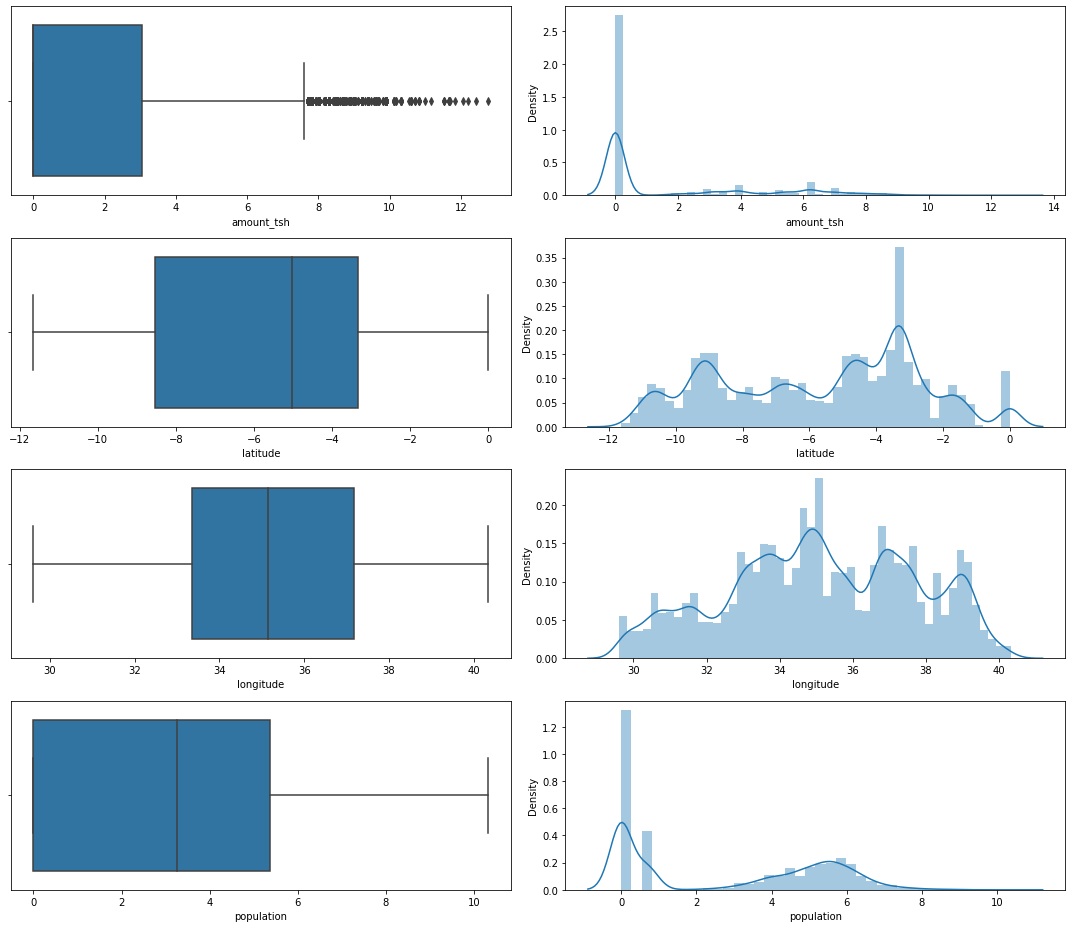

In [13]:
## outlier detection and treatment
# log transformation on skewed data so it more resembles normal distribution
water_pumps_df['population'] = (water_pumps_df['population']+1).transform(np.log)
water_pumps_df['amount_tsh'] = (water_pumps_df['amount_tsh']+1).transform(np.log)

# check boxplots and density plots
numeric_columns = ['amount_tsh', 'latitude', 'longitude', 'population']
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
for i, col in enumerate(numeric_columns):
    sns.boxplot(x= water_pumps_df[col], ax = ax[i,0])
    sns.distplot(water_pumps_df[col], ax = ax[i,1])
plt.tight_layout()

# bin features with clear distinctive distribution
water_pumps_df['amount_tsh'] = pd.cut(x=water_pumps_df['amount_tsh'], 
    bins=[-1, 5, np.inf], 
    labels=['Low', 'High'])

display(water_pumps_df.head())

In [14]:
############# FEATURE ENGINEERING #############
from sklearn.preprocessing import LabelEncoder, StandardScaler

# check feature importance with Pearson correlation coefficient
print(water_pumps_df.corr())

# create new feature 'year' from date recorded
water_pumps_df['year_recorded'] = water_pumps_df['date_recorded'].dt.year
water_pumps_df = water_pumps_df.drop(columns=['date_recorded'])

            gps_height  longitude  latitude  population
gps_height    1.000000  -0.021149 -0.035751    0.448577
longitude    -0.021149   1.000000 -0.280291    0.278088
latitude     -0.035751  -0.280291  1.000000   -0.124117
population    0.448577   0.278088 -0.124117    1.000000


In [15]:
## Reduce number of features with dimensionality reduction techniques
from prince import PCA, MCA

# Standardize data
numeric_columns = water_pumps_df.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
scaler.fit(water_pumps_df[numeric_columns])
water_pumps_df[numeric_columns] = scaler.transform(water_pumps_df[numeric_columns])

# PCA on numerical data columns
pca = PCA(n_components=1, n_iter=3)
water_pumps_pca = pca.fit_transform(water_pumps_df[numeric_columns])
water_pumps_pca = water_pumps_pca.rename(columns={0: "pca"})

# add result of PCA to dataframe
water_pumps_pca.reindex(water_pumps_df.index)
water_pumps_df = water_pumps_df.join(water_pumps_pca)

# drop numeric columns -- as they are now combined into one feature column with PCA
water_pumps_df = water_pumps_df.drop(columns=numeric_columns)

# MCA on categorical data columns
# TO DO: does not work yet -- perhaps one hot encoding and then PCA (though not recommended)

# mca = MCA(n_components=2, n_iter=3)
# print("Starting MCA...")
# water_pumps_mca = mca.fit(cat_data.iloc[:10, :])
# print(water_pumps_mca.shape)

In [16]:
## set X (features) and y (target) -- saves time to do it now rather than after feature encoding
y = water_pumps_df['status_group']
X = water_pumps_df.drop(columns=['status_group'])

In [17]:
## encoding categorical variables
# drop columns with too many categories
X = X.drop(columns=['installer', 'wpt_name', 'subvillage', 'ward'])

# retrieve column names
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()

# label encoding for ordinal data
to_label_encode = ['amount_tsh', 'construction_year_group', 'water_quality', 'quantity']
X[to_label_encode] = X[to_label_encode].apply(LabelEncoder().fit_transform)

# one hot encoding for non-ordinal data
to_hot_encode = set(categorical_columns) - set(to_label_encode)
X = pd.get_dummies(X, columns=to_hot_encode, drop_first=True)

In [19]:
## verify data set
print(X.shape, y.shape)

(59400, 252) (59400,)


In [67]:
def train(X_train, X_test, y_train, y_test, model):
    """This functions trains and tests a classifier on data X_train and X_test resp.

    Input arguments:
    X_train: training feature data
    y_train: training target data
    X_test: training feature data
    y_test: training target data
    model: classification model, e.g. XGBClassifier()

    Returns fitted model and array of predictions
    """

    # train model
    print("Training model...")
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # explain the model's predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # visualize feature importance
    shap.summary_plot(shap_values, X, plot_type="bar", class_names=model.classes_)

    return model, y_pred

def evaluate(y_test, y_pred, model):
    """Evaluates model performance by calculating accuracy and confusion matrix

    Input arguments:
    y_test: actual target values
    y_pred: predicted target values
 
    """

    # determine model performance
    print("Evaluating model...")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    cm = confusion_matrix(y_test, y_pred)

    # plot confusion matrix as heatmap
    labels = model.classes_
    labels_T = labels.transpose() + ' (pred)'
    sns.heatmap(cm / np.sum(cm), annot=True, xticklabels=labels, yticklabels=labels_T, fmt='.1%', cmap='Blues')
    plt.show()

Training model...


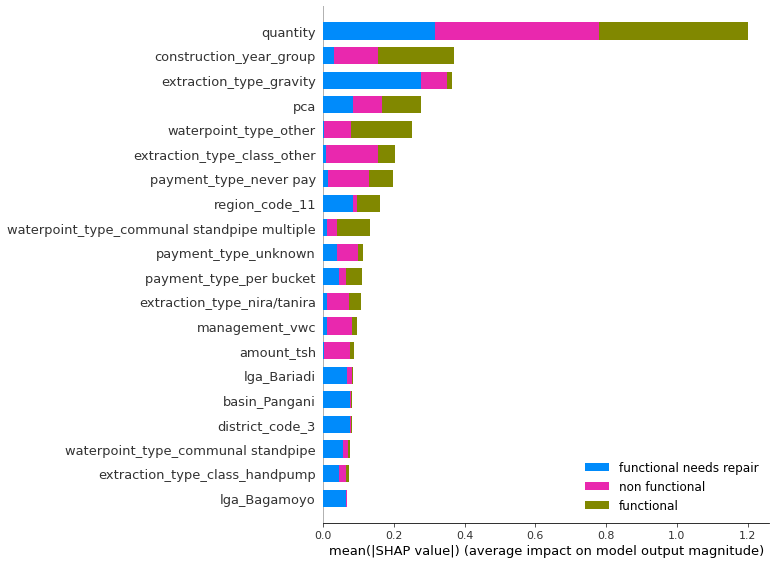

Evaluating model...
Accuracy: 78.44%


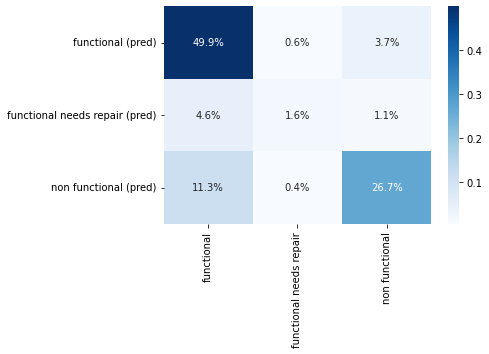

In [69]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import shap 

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# define model
clf = LGBMClassifier(random_state=0)

# train model
model, y_pred = train(X_train, X_test, y_train, y_test, clf)

# determine model performance
evaluate(y_test, y_pred, model)